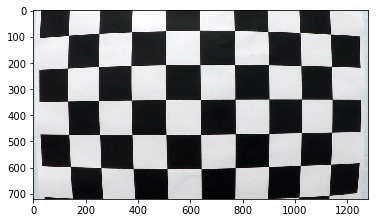

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

# Read and show a calibration image
img = cv2.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

### Compute the camera calibration using chessboard images

In [2]:
# Read in and make a list of all calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points or corners in image plane

height, width = 6, 9

# Prepare object points, like (0,0,0), (1,0,0),......(8,5,0)
objp = np.zeros((height*width,3), np.float32)
objp[:,:2] = np.mgrid[0:width, 0:height].T.reshape(-1,2) # x, y cordinates

for idx, image in enumerate(images):
    img = cv2.imread(image)
    #plt.imshow(img)
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (width,height), None)

    if ret==True:
        # Draw detected corners on an image
        cv2.drawChessboardCorners(img, (width,height), corners, ret)
        
        # Update points
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Save image  
        cv2.imwrite('./Corners_found/corners_found'+str(idx)+'.jpg', img)
        
        # Also provides some interval before reading next frame so that we can adjust 
        # our chess board in different direction
#         cv2.imshow('img', img)
#         cv2.waitKey(500)
        
# cv2.destroyAllWindows()

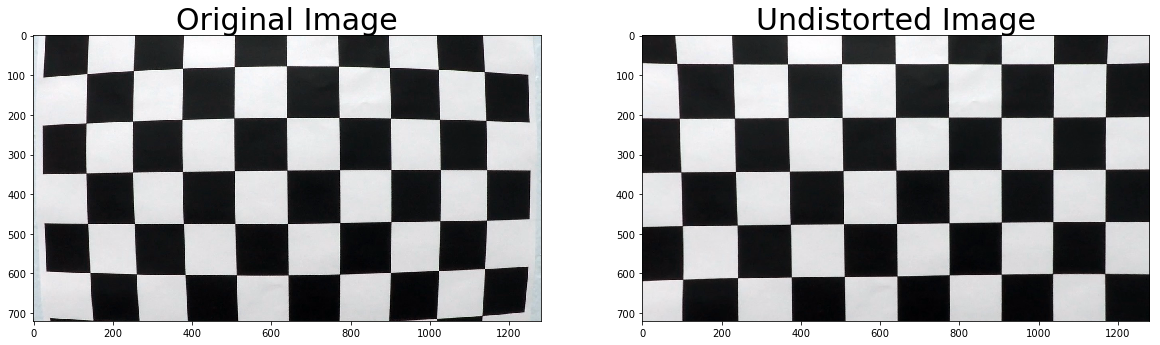

In [3]:
img = cv2.imread('./camera_cal/calibration1.jpg')

# Image size (width, height)
img_size = (img.shape[1], img.shape[0])
        
# Calibrate cameras
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Undistorting image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save undistorted images
cv2.imwrite('./Undistorted_Images/undst_calibration1'+'.jpg',dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/camera_dist_pickle.p", "wb"))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('./output_img/camera_calibration_example'+'.jpg')

# Test on a video image

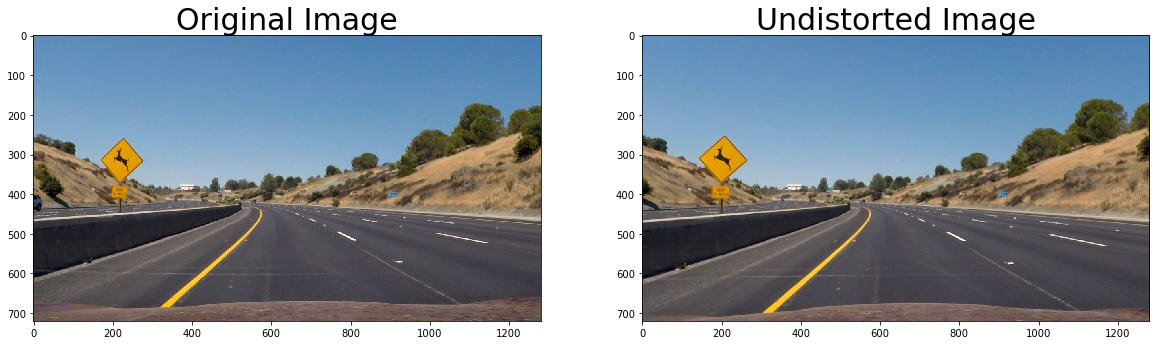

In [6]:

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open("./camera_cal/camera_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in a test image
img = mpimg.imread('./test_images/test2.jpg')

# Image size (width, height)
img_size = (img.shape[1], img.shape[0])
        
# Undistorting image
dst = cv2.undistort(img, mtx, dist, None, mtx)

mpimg.imsave('./output_img/test2_undist'+'.jpg', dst)

# Save undistorted images
#plt.savefig('./Undistorted_Images/test2'+'.jpg')

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('./output_img/test2_udist_example.jpg')

### Thresholding

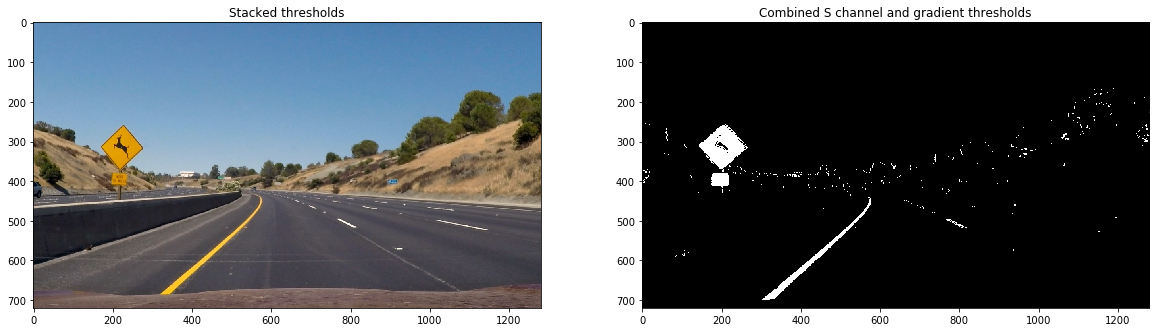

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    '''Calculated directional gradient'''
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if(orient=='x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if(orient=='y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8 bit(0-255) then convert to type=np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel>thresh[0]) & (scaled_sobel<thresh[1])] = 1
    
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    '''Calculate gradient magnitude'''
   
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x and y 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    
    # Scale to 8 bit(0-255) then convert to type=np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])] = 1
    
    return sbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''Calculate gradient '''
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x and y 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arc_results = np.arctan2(sobely, sobelx)
    
#     # Scale to 8 bit(0-255) then convert to type=np.uint8
#     arc_results = np.uint8(255*arc_results/np.max(arc_results))
    
    # Create a binary mask where direction thresholds are met
    binary_out = np.zeros_like(arc_results)
    binary_out[(arc_results>thresh[0]) & (arc_results<thresh[1])] = 1
    
    return binary_out

def hls_color(img, thresh=(0,255)):
    '''We already saw that standard grayscaling lost color information for
       the lane lines. So using hls color channel'''
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # Scale to 8 bit(0-255) then convert to type=np.uint8
    #S = np.uint8(255*S/np.max(S))
    
    # Apply a mask to S channel
    binary_out = np.zeros_like(S)
    binary_out[(S>thresh[0]) & (S<=thresh[1])] = 1
    
    return binary_out


def combined_thresh(image):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(80, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(80, 255))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(100, 255))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    s_binary = hls_color(image, thresh=(170, 255))

    combined = np.zeros_like(dir_binary)
    combined[(gradx ==1| ((mag_binary == 1)&(dir_binary == 1))) | s_binary == 1] = 1
    
    return combined

# Choose a Sobel kernel size
# Taking the gradient over larger regions can smooth over noisy intensity fluctuations on small scales. 
# Choose a larger odd number to smooth gradient measurements
ksize = 3 

image = mpimg.imread('./test_images/test2.jpg')

# Undistorting image
dst = cv2.undistort(image, mtx, dist, None, mtx)

combined = combined_thresh(dst)
# Save warped image
mpimg.imsave('./output_img/test2_threshold.jpg', combined, cmap='gray')
#mpimg.imsave('./output_img/test2_threshold.jpg', combined)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(image)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined, cmap='gray')
plt.savefig('./output_img/test2_threshold_example.jpg')

### Perspective Transform

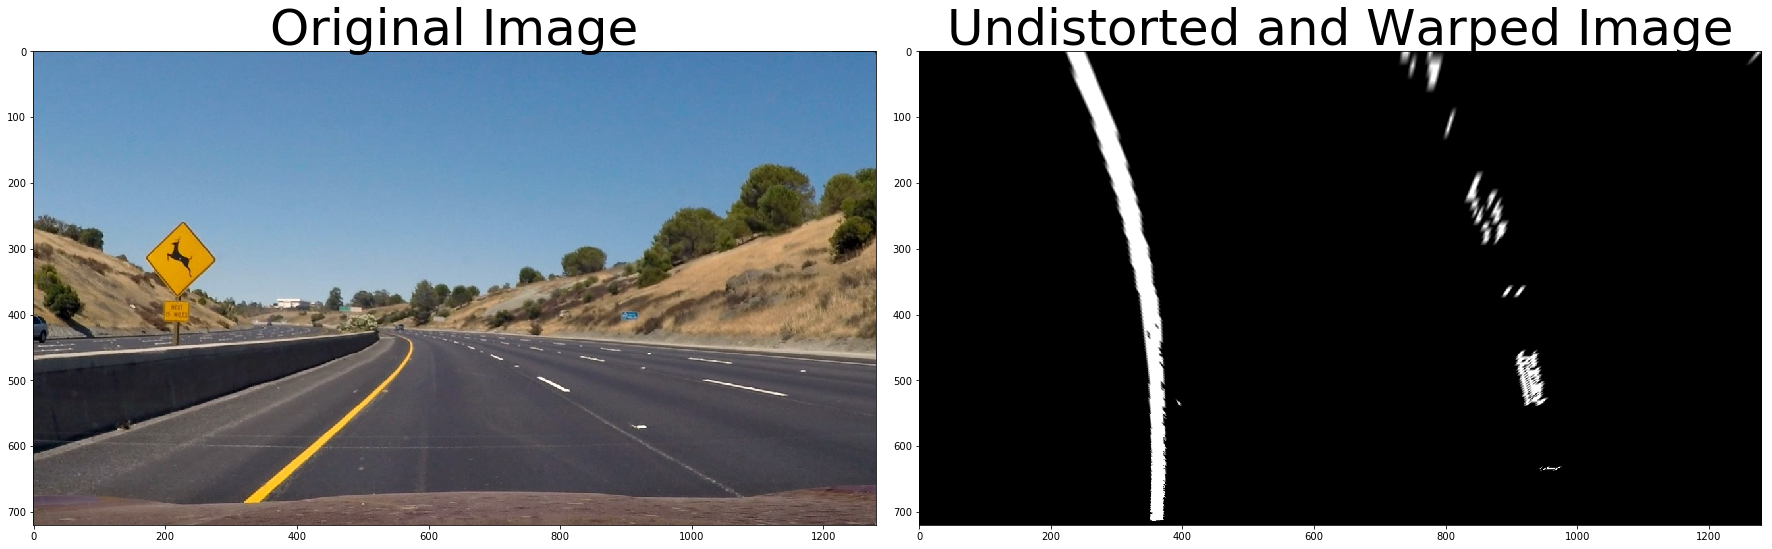

In [9]:

def perspective_transorm(img):
    
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    # Note: you could pick any four of the detected corners 
    # as long as those four corners define a rectangle
    # VOne especially smart way to do this would be to use four well-chosen
    # corners that were automatically detected during the undistortion steps
    # We recommend using the automatic detection of corners in your code
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    # e) use cv2.warpPerspective() to warp your image to a top-down view           
    
    offset = 250
    # Draw corners
    #cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
   # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    gray=img
    # Grab the image size (width, height)
    img_size = (gray.shape[1], gray.shape[0])
        
    src = np.float32([[200,img_size[1]], [1200, img_size[1]],\
                      [700,450], [585,450]])
    dst = np.float32([[300, img_size[1]],[960, img_size[1]],\
                      [960, 0],[300, 0]])
    
    #src = np.float32([[gray.shape[1]/2, gray.shape[0]/2-offset],[gray.shape[1], offset],[gray.shape[1], gray.shape[0]-offset],[gray.shape[1]/2, gray.shape[0]/2+offset]])
    #dst = np.float32([[300, 720],[980, 720],[300, 0],[980, 0]])
        
    # Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Calculate the inverse perspective matrix (Minv)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
        
    # Warp the image
    warped = cv2.warpPerspective(gray, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, M_inv


# Read in an image
img = mpimg.imread('./test_images/test2.jpg')
#img = mpimg.imread('./output_img/test6_threshold.jpg')
nx = 9
ny = 6
#undist = combined_thresh(img)

# Undistorting image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Combined thresh
combined = combined_thresh(undist)

# top_down also mean binary_warped
top_down, perspective_M, M_inv = perspective_transorm(combined)
mpimg.imsave('./output_img/test2_binary_warped_gray.jpg', top_down, cmap='gray')
# Visualize images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_img/test2_binary_warped_example.jpg')

## Locate the Lane Lines and Fit a Polynomial

(720, 1280)


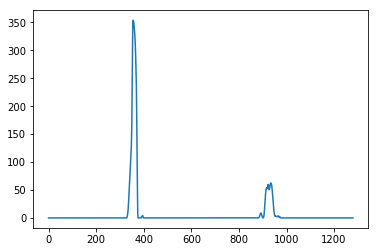

In [10]:
import numpy as np
#img = mpimg.imread('./output_img/test2_bird_view_gray.jpg')
img=top_down
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
print(img.shape)

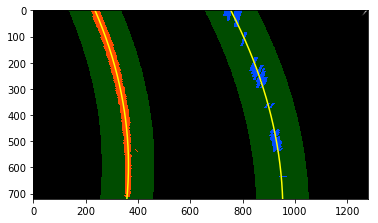

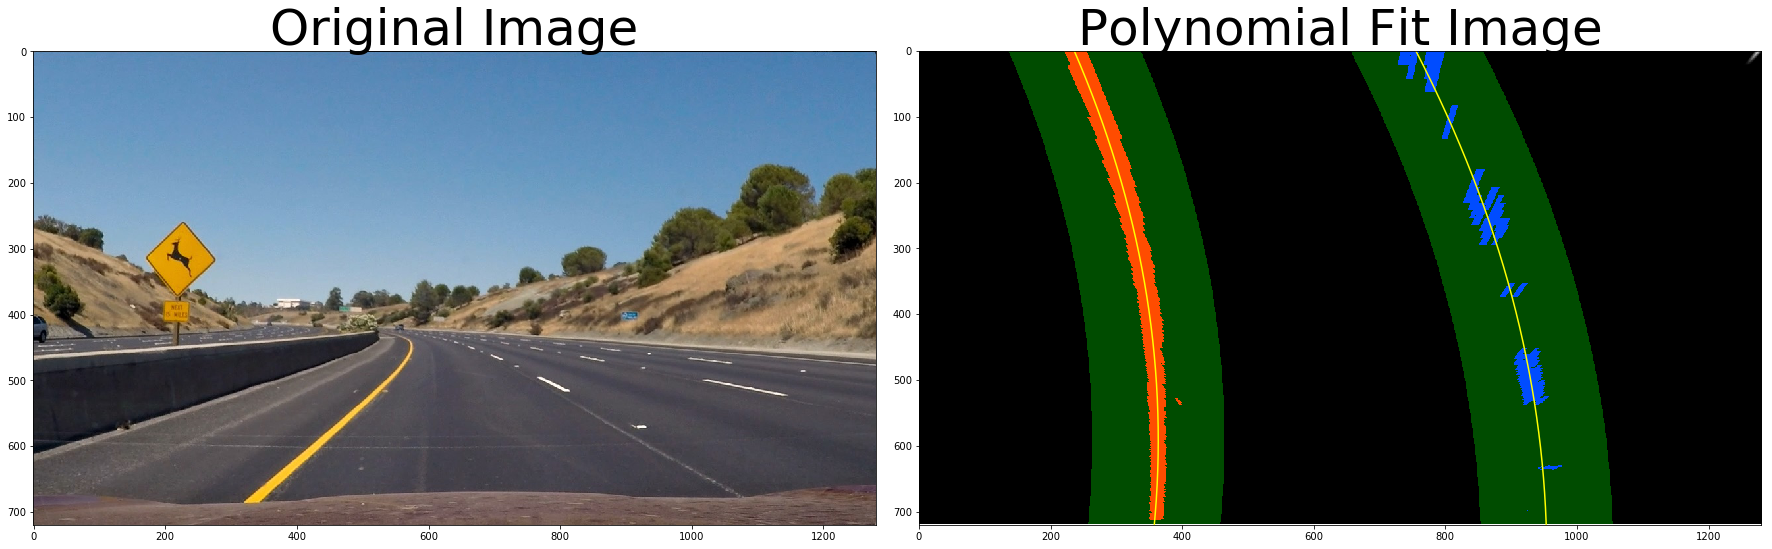

In [23]:
def line_fit(binary_warped):
    '''Find and fit lines'''
    
   # binary_warped=cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
    #plt.imshow(binary_warped)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
   
    # Check whether we find enough points
    # If not enough points, return None with error
    min_inds = 10
    if leftx.size < min_inds or rightx.size < min_inds:
        return None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(binary_warped)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    # Save parameters for calculate curvatures
    curv_pickle = {}
    curv_pickle["leftx"] = leftx
    curv_pickle["rightx"] = rightx
    curv_pickle["lefty"] = lefty
    curv_pickle["righty"] = righty
    curv_pickle["left_fit"] = left_fit
    curv_pickle["right_fit"] = right_fit
#     curv_pickle["left_lane_inds"] = left_lane_inds
#     curv_pickle["right_lane_inds"] = right_lane_inds
    
    return curv_pickle

def line_fit_visualize(binary_warped, curv_pickle):
    '''visualize for line fit images'''
    
    # Load parameters
    left_fit = curv_pickle["left_fit"]
    right_fit = curv_pickle["right_fit"]
    leftx = curv_pickle["leftx"]
    lefty = curv_pickle["lefty"]
    rightx = curv_pickle["rightx"]
    righty = curv_pickle["righty"]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    

def advanced_fit(binary_warped, left_fit, right_fit):
    '''Assume you know where the lines are you have a fit! In the next frame of video you don't 
       need to do a blind search again, but instead you can just search in a margin around the 
       previous line position'''
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print(leftx.size,rightx.size)
    
    # Check whether we find enough points
    # If not enough points, return None with error
    min_inds = 10
    if leftx.size < min_inds or rightx.size < min_inds:
        return None
   
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
#     # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
    # Save parameters for later use
    curv_pickle ={}
    curv_pickle["left_fit"] = left_fit
    curv_pickle["right_fit"] = right_fit
    curv_pickle["leftx"] = leftx
    curv_pickle["rightx"] = rightx
    curv_pickle["lefty"] = lefty
    curv_pickle["righty"] = righty
    
    return curv_pickle

def advanced_fit_visualize(binary_warped, curv_pickle):
    '''visualize for advanced fit images'''
    
    # Load parameters
    left_fit = curv_pickle["left_fit"]
    right_fit = curv_pickle["right_fit"]
    leftx = curv_pickle["leftx"]
    lefty = curv_pickle["lefty"]
   
    rightx = curv_pickle["rightx"]
    righty = curv_pickle["righty"]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty,leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    margin = 100
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
    

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open("./camera_cal/camera_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in a test image
img = mpimg.imread('./test_images/test2.jpg')
        
# Undistorting image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Combined thresh
combined = combined_thresh(undist)

# Warped image
binary_warped, _, Minv = perspective_transorm(combined)

# # Line fit
curv_pickle=line_fit(binary_warped)

advanced_fit_visualize(binary_warped, curv_pickle)
plt.savefig('./output_img/test2_polynomial_fit.jpg' )

# Visualize images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(polynomial_fit)
advanced_fit_visualize(binary_warped, curv_pickle)
ax2.set_title('Polynomial Fit Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_img/test2_polynomial_fit_example.jpg')

## Calculate curvature and offset

In [29]:
def calculate_curvature(leftx, rightx, lefty, righty):
    '''Calculate the radius of curvature in meters'''
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = np.max(ploty)
    y_eval = 719
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return left_curverad, right_curverad

def calculate_offset(undist, left_fit, right_fit):
    '''Calculate the offset of the lane center from the center of the image'''
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = undist.shape[1]
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    offset = (left_fitx+right_fitx)/2 - ploty/2
    offset = xm_per_pix*offset
    
    return offset

def final_drawing(undist, left_fit, right_fit, left_curverad, right_curverad, Minv, vehicle_offset):
    '''Project the measurement back down onto the original undistorted image of the road'''
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warped = np.zeros((720,1280))
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Anotate curvature values 
    ave_curvature = (left_curverad + right_curverad)/2
    ave_text = 'Radius of average curvature: %.2f m'%ave_curvature
    cv2.putText(result, ave_text,(50,50), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    
    # Anotate vehicle offset from the lane center
    if(vehicle_offset>0):
        offset_text = 'Vehicle right offset from lane center: {:.2f} m'.format(vehicle_offset)
    else:
        offset_text = 'Vehicle left offset from the lane center: {:.2f} m'.format(-vehicle_offset)
    cv2.putText(result, offset_text,(50,80), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    
    #plt.imshow(result)
    
    return result

In [30]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n):
        # How many frames to use to smooth
        self.n = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        # Line smoothing
        # Second order polynomial curve, f(y) = A*y**2+B*y+c
        self.A = []
        self.B = []
        self.C = []
        self.ave_A = 0
        self.ave_B = 0
        self.ave_C = 0
        
        # Smooth curvature
        self.curv = []
        #self.right_curv = []
        self.ave_curv = 0
        #self.ave_right_curv = 0
        
    def add_to_smooth_fit(self, polynomial_fit):
        '''Smoothing over the last n frames'''
        
        self.A.append(polynomial_fit[0])
        self.B.append(polynomial_fit[1])
        self.C.append(polynomial_fit[2])
        
        # Keep size of A|B|C equal to n
        if len(self.A)>self.n:
            self.A.pop(0)
            self.B.pop(0)
            self.C.pop(0)
        
        self.ave_A = np.mean(self.A)
        self.ave_B = np.mean(self.B)
        self.ave_C = np.mean(self.C)
        
        return self.ave_A, self.ave_B, self.ave_C   
    
    def ave_curvature(self, curvature):
        '''For a frame without detected lanes, 
           we assign average curvature to that frame'''
        
        self.curv.append(curvature)
        #self.right_curv.append(right_curvature)
        
        # Keep size of left_curv|rightcurv equal to n
        if len(self.curv)>self.n:
            self.curv.pop(0)
        #    self.right_curv.pop(0)
            
        self.ave_curv = np.mean(self.curv)
        #self.ave_right_curv = np.mean(self.right_curv)
        
        return self.ave_curv
    
    def get_results_of_smooth_fit(self):
        return self.ave_A, self.ave_B, self.ave_C
    
    def get_results_of_ave_curvature(self):
        return self.ave_curv

In [31]:
# Define number of frames for smoothing
num_frames = 5
left_lanes = Line(n=num_frames) 
right_lanes = Line(n=num_frames)
detected = False 


def process_video_image(img):
    '''Process each image in the video and return with annotated image'''
    
    global detected, mtx, dist, left_lanes, right_lanes
    # Undistorting image
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Combined thresh
    combined = combined_thresh(undist)

    # Warped image
    binary_warped, _, Minv = perspective_transorm(combined)

    # Line fit
    if not detected:
        curv_pickle = line_fit(binary_warped)
        
        if curv_pickle is not None:
            left_fit = curv_pickle["left_fit"]
            right_fit = curv_pickle["right_fit"]
            leftx = curv_pickle["leftx"]
            lefty = curv_pickle["lefty"]
            rightx = curv_pickle["rightx"]
            righty = curv_pickle["righty"]

            # Update
            # Add into the set to smoothing average fit
            left_fit = left_lanes.add_to_smooth_fit(left_fit)
            right_fit = right_lanes.add_to_smooth_fit(right_fit)

            # Calculate curvature
            # Assume first frame can be detected both lanes and curvatures 
            left_curvature, right_curvature = calculate_curvature(leftx, rightx, lefty, righty)

#             # Add into the set to smoothing average curvature
#             # Only use for a frame without detected lanes
#             special_left_curv = left_lanes.ave_curvature(left_curvature)
#             special_right_curv = right_lanes.ave_curvature(right_curvature)

            detected = True
        else:
            # Calculate based on previous frames
            left_fit = left_lanes.get_results_of_smooth_fit()
            right_fit = right_lanes.get_results_of_smooth_fit()
            special_left_curv = left_lanes.get_results_of_ave_curvature()
            special_right_curv = right_lanes.get_results_of_ave_curvature()
            left_curvature, right_curvature = special_left_curv, special_right_curv
            detected = False
    else:
        # Smooth fit
        left_fit = left_lanes.get_results_of_smooth_fit()
        right_fit = right_lanes.get_results_of_smooth_fit()
        
        # Add into the set to smoothing average curvature
        # Only use for a frame without detected lanes
        special_left_curv = left_lanes.get_results_of_ave_curvature()
        special_right_curv = right_lanes.get_results_of_ave_curvature()
        
        # Skip the sliding windows step once you know where the lines are
        # Search in a margin around the previous line position 
        curv_pickle = advanced_fit(binary_warped, left_fit, right_fit)
        
        if curv_pickle is not None:
            # Detected lines 
            left_fit = curv_pickle["left_fit"]
            right_fit = curv_pickle["right_fit"]
            leftx = curv_pickle["leftx"]
            lefty = curv_pickle["lefty"]
            rightx = curv_pickle["rightx"]
            righty = curv_pickle["righty"]
            
            # Note: We only make update when detect lanes in the current frame
            # Add into the set to smoothing average fit
            left_fit = left_lanes.add_to_smooth_fit(left_fit)
            right_fit = right_lanes.add_to_smooth_fit(right_fit)
            
            # Calculate curvature
            left_curvature, right_curvature = calculate_curvature(leftx, rightx, lefty, righty)
        else:
            # Calculate curvature based on previous frames
            left_curvature, right_curvature = special_left_curv, special_right_curv
            detected =False
            
        
    # Calculate vehicle offset from the lane center in the image
    vehicle_offset = calculate_offset(undist, left_fit, right_fit)
    
    # Project the measurement back down onto the original undistorted image of the road
    result = final_drawing(undist, left_fit, right_fit, left_curvature, right_curvature, Minv, vehicle_offset)
    
    return result
   

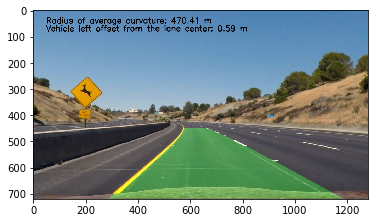

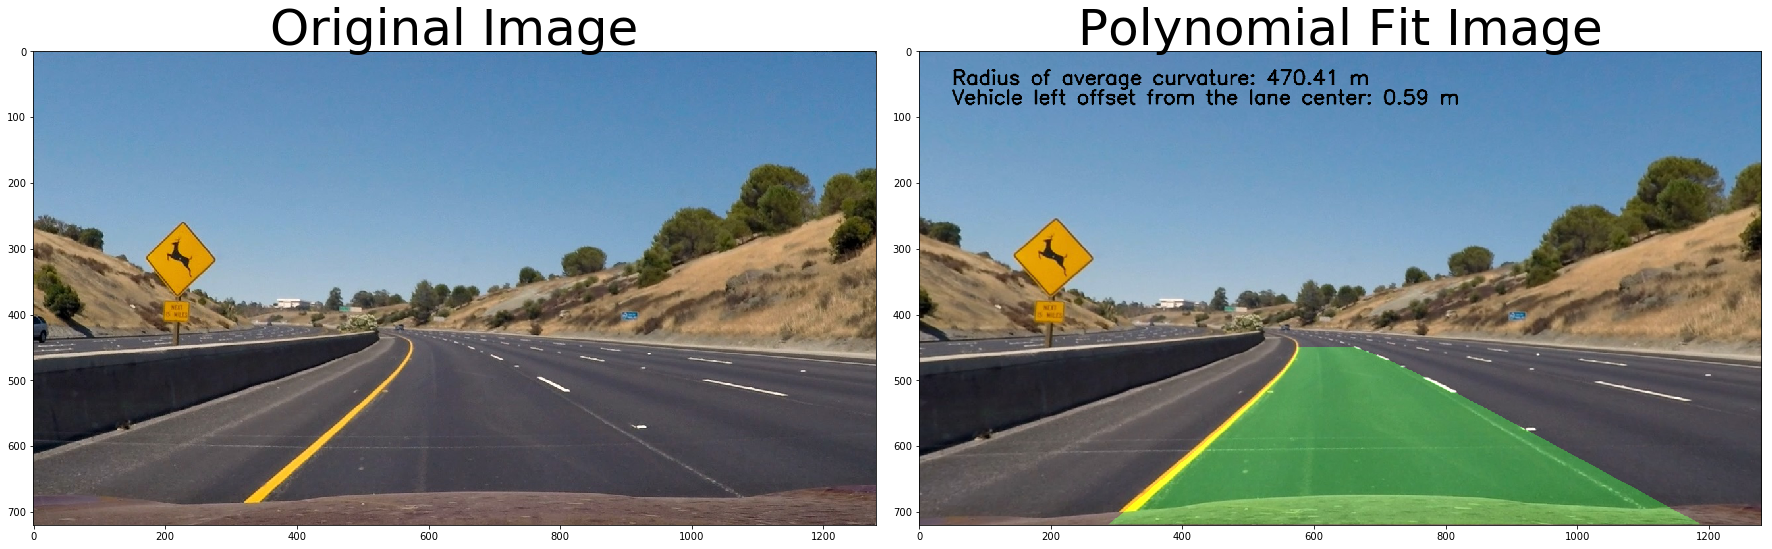

In [32]:
# Define number of frames for smoothing
num_frames = 5
left_lanes = Line(n=num_frames) 
right_lanes = Line(n=num_frames)
detected = False 

img = mpimg.imread('./test_images/test2.jpg')
result = process_video_image(img)
plt.imshow(result)

mpimg.imsave('./output_img/test2_final_projected.jpg', result)

# Visualize images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('Polynomial Fit Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_img/test2_final_projected_example.jpg')

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define number of frames for smoothing
num_frames = 5
left_lanes = Line(n=num_frames) 
right_lanes = Line(n=num_frames)
detected = False 

white_output = 'project_demo.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_video_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_demo.mp4
[MoviePy] Writing video project_demo.mp4


100%|█████████▉| 1260/1261 [06:08<00:00,  2.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_demo.mp4 

